In [1]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('white')
%matplotlib inline

In [71]:
axis_color = "0.4"
non_accent_light = "#dbdbdb"
non_accent_dark = "#cccccc"
non_accent_dark = "#bdbdbd"
accent = "#4599ff"
palette = sns.color_palette([non_accent,accent])

In [81]:
def format_line_chart(title,axes,x_label_format='{:,.1f}',x_label_scale=1,y_label_format='{:,.1f}',y_label_scale=1,color="black"):
    plt.title(title,y=1.05, color=color)

    axes.set_xticks(axes.get_xticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
    axes.set_xticklabels([x_label_format.format(x) for x in (axes.get_xticks()/x_label_scale).tolist()])
    
    axes.set_yticks(axes.get_yticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
    axes.set_yticklabels([y_label_format.format(x) for x in (axes.get_yticks()/y_label_scale).tolist()])

    axes.spines['bottom'].set_color(color)
    axes.xaxis.label.set_color(color)
    axes.tick_params(axis='x', colors=color)

    axes.spines['left'].set_color(color)
    axes.yaxis.label.set_color(color)
    axes.tick_params(axis='y', colors=color)

    sns.despine()    

## Data processing

In [85]:
econ_df = pd.DataFrame()

In [86]:
temp = pd.read_csv('./data/ABMI-290920.csv')

temp = temp[temp['Title'].str.isnumeric()]

temp.columns = ['year','GDP']

temp['GDP'] = pd.to_numeric(temp['GDP'])
temp['year'] = pd.to_numeric(temp['year'])
#temp['GDP growth'] = temp['GDP'].pct_change()

temp.index = temp['year']
temp = temp.drop('year',axis=1)

econ_df = pd.concat([econ_df,temp],join='outer',axis=1)

In [87]:
temp = pd.read_csv('./data/QWND-290920.csv')

temp = temp[temp['Title'].str.isnumeric()]

temp.columns = ['year','disposable income']

temp['disposable income'] = pd.to_numeric(temp['disposable income'])
temp['year'] = pd.to_numeric(temp['year'])
#temp['disposable income growth'] = temp['disposable income'].pct_change()

temp.index = temp['year']
temp = temp.drop('year',axis=1)

econ_df = pd.concat([econ_df,temp],join='outer',axis=1)

In [89]:
hist_df = econ_df

## Monte Carlo Simulation

In [91]:
iterations = 750
years_to_project = 10

In [90]:
initial_year = 2020
initial_GDP = hist_df.loc[initial_year-1]['GDP']

In [99]:
GDP_mean = 0.024383720592148272        #Historical average of YoY growth in the period from 1956 to 2019
GDP_std_dev = 0.020191051459338794     #Historical stdev of YoY growth in the period from 1956 to 2019

## Sandbox

### Tutorial example of a regression model using scikit-learn

In [13]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [14]:
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)
diabetes_X = diabetes_X[:, np.newaxis, 2]

In [32]:
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

In [35]:
regr = linear_model.LinearRegression()

In [43]:
regr.fit(diabetes_X_train,diabetes_y_train)

LinearRegression()

In [44]:
diabetes_y_predict = regr.predict(diabetes_X_test)

In [45]:
regr.coef_

array([938.23786125])

In [46]:
mean_squared_error(diabetes_y_test,diabetes_y_predict)

2548.0723987259694

In [47]:
r2_score(diabetes_y_test,diabetes_y_predict)

0.47257544798227147

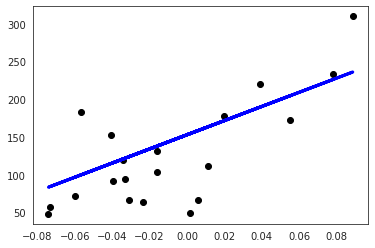

In [49]:
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_predict, color='blue', linewidth=3)

### Regression of historical GDP vs Disposable Income

In [5]:
regr = linear_model.LinearRegression()

In [6]:
regr.fit(econ_df['GDP'].to_numpy().reshape(-1,1),econ_df['disposable income'])

LinearRegression()

In [7]:
disp_income_predict = regr.predict(econ_df['GDP'].to_numpy().reshape(-1,1))

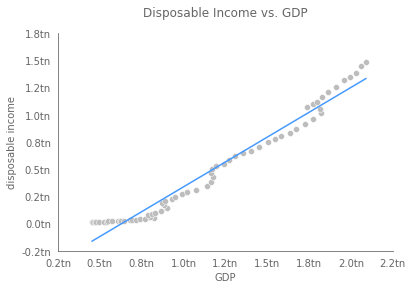

In [82]:
#plt.scatter(econ_df['GDP'].to_numpy().reshape(-1,1),econ_df['disposable income'],color='black')
#plt.plot(econ_df['GDP'].to_numpy().reshape(-1,1), disp_income_predict, color='blue', linewidth=3)

sns.scatterplot(x=econ_df['GDP'],
                y=econ_df['disposable income'],
                color=non_accent_dark)
ax = sns.lineplot(x=econ_df['GDP'],
             y=disp_income_predict,
            color=accent)

format_line_chart("Disposable Income vs. GDP",
                  ax,
                  x_label_scale=1000000,
                  x_label_format='{:,.1f}tn',
                  y_label_scale=1000000,
                  y_label_format='{:,.1f}tn',
                  color=axis_color)

In [54]:
r2 = round(r2_score(econ_df['disposable income'],disp_income_predict),2)
intercept = humanize.intcomma(regr.intercept_,1)
coefficient = humanize.intcomma(regr.coef_[0],2)

##### Disposable Income vs GDP

Disposable Income = {{intercept}} + {{coefficient}} * GDP

The regression has an R2 of {{r2}} 

### Historical behaviour: GDP YoY change

In [120]:
used = np.random.normal(GDP_mean, GDP_std_dev, 500)

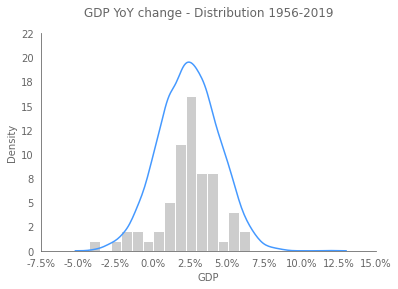

In [131]:
ax = sns.kdeplot(np.random.normal(GDP_mean, GDP_std_dev, 5000),
                  color=accent)
ax = sns.histplot(hist_df['GDP'].pct_change(),
                  bins=15,
                  color=non_accent_dark)
format_line_chart("GDP YoY change - Distribution 1956-2019",
                  ax,
                  x_label_format='{:,.1%}',
                  y_label_format='{:,.0f}',
                  color=axis_color)

In [114]:
gdp_yoy_change_mean = '{:.2%}'.format(hist_df['GDP'].pct_change().mean())

In [116]:
gdp_yoy_change_stdev = '{:.2%}'.format(hist_df['GDP'].pct_change().std())

##### GDP YoY change historical behaviour (1956-2019)

Average YoY GDP change {{gdp_yoy_change_mean}}

Yoy GDP change Standard Deviation {{gdp_yoy_change_stdev}}